# Exploratory Data Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob

import noisereduce as nr

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Local file path

### Only use 6db sample
* Experiment with using 0db or -6dB samples as we do not have baseline background noise

In [2]:

# audio_files = glob('/Users/jaimacabangon/Downloads/slider_0db/*/*/*.wav')
# audio_files_minus_6 = glob('/Users/jaimacabangon/Downloads/slider_-6db/*/*/*.wav')
audio_files = glob('/Users/jaimacabangon/Downloads/slider_6db/*/*/*.wav')
# audio_files_fan_0 = glob('/Users/jaimacabangon/Downloads/fan_0db/*/*/*.wav')
# audio_files_fan_minus_6 = glob('/Users/jaimacabangon/Downloads/fan_-6db/*/*/*.wav')
audio_files_fan_6 = glob('/Users/jaimacabangon/Downloads/fan_6db/*/*/*.wav')
# audio_files_pump_0 = glob('/Users/jaimacabangon/Downloads/pump_0db/*/*/*.wav')
# audio_files_pump_minus_6 = glob('/Users/jaimacabangon/Downloads/pump_-6db/*/*/*.wav')
audio_files_pump_6 = glob('/Users/jaimacabangon/Downloads/pump_6db/*/*/*.wav')
# audio_files_valve_0 = glob('/Users/jaimacabangon/Downloads/valve_0db/*/*/*.wav')
# audio_files_valve_minus_6 = glob('/Users/jaimacabangon/Downloads/valve_-6db/*/*/*.wav')
audio_files_valve_6 = glob('/Users/jaimacabangon/Downloads/valve_6db/*/*/*.wav')


# audio_files.extend(audio_files_6)
# audio_files.extend(audio_files_minus_6)


# audio_files.extend(audio_files_fan_0)
# audio_files.extend(audio_files_fan_minus_6)
audio_files.extend(audio_files_fan_6)

# audio_files.extend(audio_files_pump_0)
# audio_files.extend(audio_files_pump_minus_6)
audio_files.extend(audio_files_pump_6)

# audio_files.extend(audio_files_valve_0)
# audio_files.extend(audio_files_valve_minus_6)
audio_files.extend(audio_files_valve_6)


# Create initial Dataframe
* Split string for data frame creation
* Initial dataframe will include:
    * Machine type (slider, valve, fan, pump)
    * unique machine ID (id_NN)
    * wav file name
    * Sound type (normal vs abnormal)
    * Raw data (raw audio data)

In [3]:
test = audio_files[0]
new = test.split('/')
print(new)

['', 'Users', 'jaimacabangon', 'Downloads', 'slider_6db', 'id_00', 'abnormal', '00000059.wav']


In [4]:
raw_data_list = [] 
sample_rate_list = []
sound_source_list = [] 
binary_classification_list = [] 
wav_file_list = [] 
name_classification_list = []

for audio_file in audio_files:
    split_string = str(audio_file).split('/')
    sound_source = split_string[4]
    name_classification = sound_source.split("_")[0]
    binary_classification = split_string[6]
    wav_file = split_string[7]
    raw_data, sample_rate = librosa.load(audio_file, sr=None)
    sound_source_list.append(sound_source)
    binary_classification_list.append(binary_classification)
    wav_file_list.append(wav_file)
    raw_data_list.append(raw_data)
    sample_rate_list.append(sample_rate)
    name_classification_list.append(name_classification)


    

### 50k samples average time to DF ~5mins

In [5]:
df = pd.DataFrame(columns=["Sound Source","Machine Type", "Classification", ".wav File", "Sample Rate", "Raw Data"])

In [6]:
df["Sound Source"] = sound_source_list
df["Machine Type"] = name_classification_list # label for machine type 
df["Classification"] = binary_classification_list # label for 0 or 1 (normal vs abnormal)
df[".wav File"] = wav_file_list
df["Sample Rate"] = sample_rate_list
df["Raw Data"] = raw_data_list

In [7]:
df

,Sound Source,Machine Type,Classification,.wav File,Sample Rate,Raw Data
0,slider_6db,slider,abnormal,00000059.wav,16000,"[0.0011634827, 0.00012207031, -0.00046539307, ..."
1,slider_6db,slider,abnormal,00000071.wav,16000,"[0.004940033, 0.0047073364, 0.0077323914, -0.0..."
2,slider_6db,slider,abnormal,00000065.wav,16000,"[0.0025291443, 0.002922058, 0.0031700134, 0.00..."
3,slider_6db,slider,abnormal,00000273.wav,16000,"[-0.007286072, -0.0062065125, -0.0077590942, -..."
4,slider_6db,slider,abnormal,00000267.wav,16000,"[-0.0026016235, -0.0023345947, -0.002998352, -..."
...,...,...,...,...,...,...
18014,valve_6db,valve,normal,00000083.wav,16000,"[-0.0015220642, -0.0024032593, -0.0027389526, ..."
18015,valve_6db,valve,normal,00000097.wav,16000,"[-0.0033035278, -0.0030288696, -0.0026435852, ..."
18016,valve_6db,valve,normal,00000068.wav,16000,"[-0.0005912781, -1.9073486e-05, 0.00062179565,..."
18017,valve_6db,valve,normal,00000040.wav,16000,"[-0.00061035156, -0.0008201599, -0.00074768066..."


# Calculate percentage difference between mean normal RMS/ZCR and mean abnormal RMS/ZCR

$$\text{Percentage Difference} = \left| \frac{\text{abnormal RMS/ZCR} - \text{normal RMS/ZCR}}{\text{normal RMS/ZCR}} \right| \times 100$$



# Results (-6dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.009614 | 0.010491 | 9.1%
| ZCR Mean  |0.064470| 0.076893 | 19.2%

# Results (0dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.005687 | 0.006960 | 22.3%
| ZCR Mean  |0.064451| 0.086448 | 34%


# Results (6dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.004132| 0.005705| 38.0%
| ZCR Mean  |0.060384| 0.087477 | 44.86%







# Baseline Markdown folder determination

### Based on percent difference above of 9.1% (lowest), the difference between the mean of normal vs abnormal in the -6dB samples are relatively small indicating their mean are close to eachother.
### Now given the sorted sound sources above we can see the following: 
- Based on the visualizations we can see the -6dB samples have a pretty consistent .0010/.00098 RMS mean
- The sorted stats above are sorted via rms mean and rms standard deviation 
   - We see that the lowest standard deviation is for the -6dB samples.
        - Indicating that the distribution of the values in the -6dB samples are close to the mean
        - Low standard deviation means that the audio signals are consistent over time, which is typical for background noise (white noise, constant machinery noise etc)
        - This is backed by the visualizations above wether the classification is abnormal or normal the -6dB sample looks to be the least variable over time. 

# Baseline background noise

* RMS Value: -6db sample


|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.009614 | 0.010491 | 9.1%


# Filter background noise from 6dB signal
* NOTE: There is no attenuation happening here, if the audio_data is determined to be noise we zero those samples
  * Attenuation can be done but costly in compute.
     * Attenuation can also overfit our model
     * Example: take an attenuation factor if audio is determined as noise.

# Below encoding is for anomaly detection (Binary classification)
* Determine if anomaly is found (normal vs abnormal)

### Breakdown
* label_encoder: Converts each unique label to a numerical value (int)
* y: normal vs abnormal
* y_encoded = (normal = 0, abnormal = 1)
* one hot vectorizes 

In [8]:
import numpy as np
import tensorflow as tf

def build_model_binary_classification(input_shape, learning_rate=0.001):
    """Builds and compiles a simpler binary classification model."""
    tf.keras.backend.clear_session()  # Clear any previous session
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()  # Create a new model where layers can be stacked linearly
    model.add(tf.keras.layers.Input(shape=input_shape))  # Ensure we're taking the shape of 1 audio sample
    model.add(tf.keras.layers.Flatten())  # Flatten the input

    # Add simplified dense layers
    model.add(tf.keras.layers.Dense(32, activation='relu'))  # Reduced number of neurons
    model.add(tf.keras.layers.Dense(16, activation='relu'))  # Further reduced number of neurons
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Define optimizer

    model.compile(
        loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
        optimizer=optimizer,
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]  # Use tf.keras.metrics for precision and recall
    )
    
    return model


In [9]:
def create_training_data(data_frame: pd.DataFrame):
    """Create training data for mel_sgram"""
    raw_audio = []
    labels = []
    for index, row in data_frame.iterrows():
        audio_vector = np.array(row['Raw Data'])  # Convert the raw audio data from the DataFrame row to a numpy array
        sr = row['Sample Rate']  # Get the sample rate
        label = 1 if row['Classification'] == 'abnormal' else 0  # Binary classification: 1 for abnormal, 0 for normal

        # mel_sgram = generate_mel_spectrogram(audio_vector, sr)  # Generate Mel spectrogram

        # # Normalize the Mel spectrogram for consistent input size
        # img_array = cv2.normalize(mel_sgram, None, 0, 1, cv2.NORM_MINMAX)
        # img_array = img_array.astype(np.uint8)  # Convert to unsigned 8-bit integer type
        # img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel image (RGB)
        # new_img = cv2.resize(img_array, (224, 224))  # Resize to 224x224 pixels

        raw_audio.append(audio_vector)
        labels.append(label)
    
    return np.array(raw_audio), np.array(labels)

In [10]:
slider_df = df[df['Machine Type'] == 'slider']
fan_df = df[df['Machine Type'] == 'fan']
pump_df = df[df['Machine Type'] == 'pump']
valve_df = df[df['Machine Type'] == 'valve']

In [11]:
X, y = create_training_data(slider_df)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (3275, 160000), Training labels shape: (3275,)
Testing data shape: (819, 160000), Testing labels shape: (819,)


In [12]:
# Define the input shape
input_shape = (160000,)
learning_rate = 0.001

# Build the model
model_slider = build_model_binary_classification(input_shape, learning_rate)
print(model_slider.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,120,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,120,577 (19.53 MB)

 Trainable params: 5,120,577 (19.53 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
# Example shapes (already defined):
# X_train.shape == (3275, 160000)
# y_train.shape == (3275,)
# X_test.shape == (819, 160000)
# y_test.shape == (819,)

# Train the model
history_slider = model_slider.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
evaluation = model_slider.evaluate(X_test, y_test)
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Precision: {evaluation[2]}")
print(f"Test Recall: {evaluation[3]}")


Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7311 - loss: 0.5927 - precision: 0.4357 - recall: 0.3627 - val_accuracy: 0.8632 - val_loss: 0.3618 - val_precision: 0.9873 - val_recall: 0.4127
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9052 - loss: 0.2445 - precision: 0.9917 - recall: 0.5546 - val_accuracy: 0.8706 - val_loss: 0.3243 - val_precision: 0.9560 - val_recall: 0.4603
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9842 - loss: 0.0681 - precision: 0.9963 - recall: 0.9290 - val_accuracy: 0.8596 - val_loss: 0.3771 - val_precision: 0.8854 - val_recall: 0.4497
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9995 - loss: 0.0135 - precision: 1.0000 - recall: 0.9976 - val_accuracy: 0.8584 - val_loss: 0.4274 - val_precision: 0.9011 - val_recall: 0.4339
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0048 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8596 - val_loss: 0.

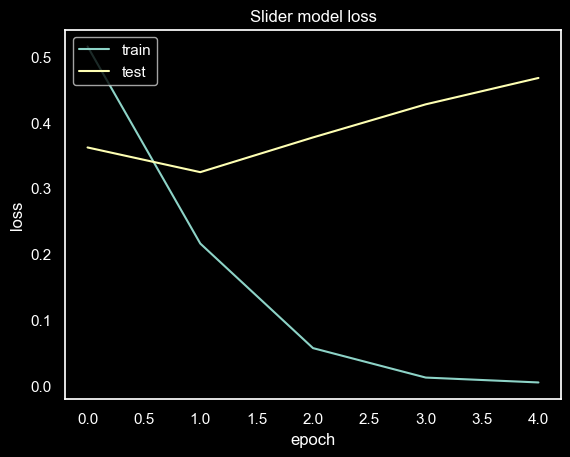

In [24]:

plt.style.use('dark_background')

plt.plot(history_slider.history['loss'])
plt.plot(history_slider.history['val_loss'])
plt.title('Slider model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
X, y = create_training_data(fan_df)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

# Define the input shape
input_shape = (160000,)
learning_rate = 0.001

# Build the model
model_fan = build_model_binary_classification(input_shape, learning_rate)
print(model_fan.summary())

Training data shape: (4440, 160000), Training labels shape: (4440,)
Testing data shape: (1110, 160000), Testing labels shape: (1110,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,120,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,120,577 (19.53 MB)

 Trainable params: 5,120,577 (19.53 MB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
# Example shapes (already defined):
# X_train.shape == (3275, 160000)
# y_train.shape == (3275,)
# X_test.shape == (819, 160000)
# y_test.shape == (819,)

# Train the model
history_fan = model_fan.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
evaluation = model_fan.evaluate(X_test, y_test)
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Precision: {evaluation[2]}")
print(f"Test Recall: {evaluation[3]}")


Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6969 - loss: 0.6083 - precision: 0.4306 - recall: 0.1647 - val_accuracy: 0.8036 - val_loss: 0.4444 - val_precision: 0.8804 - val_recall: 0.2812
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9107 - loss: 0.2346 - precision: 0.9960 - recall: 0.6731 - val_accuracy: 0.8225 - val_loss: 0.3680 - val_precision: 0.6730 - val_recall: 0.6146
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9990 - loss: 0.0252 - precision: 0.9997 - recall: 0.9968 - val_accuracy: 0.8279 - val_loss: 0.3905 - val_precision: 0.6655 - val_recall: 0.6771
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.0039 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8288 - val_loss: 0.4091 - val_precision: 0.6655 - val_recall: 0.6840
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 0.0018 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8306 - val_loss: 0.

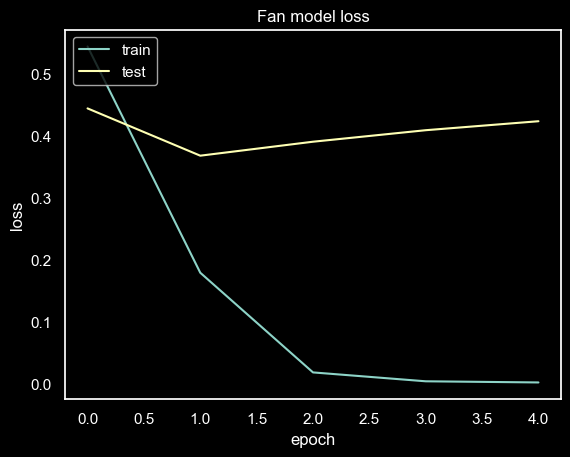

In [23]:

plt.style.use('dark_background')

plt.plot(history_fan.history['loss'])
plt.plot(history_fan.history['val_loss'])
plt.title('Fan model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
X, y = create_training_data(valve_df)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

# Define the input shape
input_shape = (160000,)
learning_rate = 0.001

# Build the model
model_valve = build_model_binary_classification(input_shape, learning_rate)
print(model_valve.summary())

Training data shape: (3336, 160000), Training labels shape: (3336,)
Testing data shape: (834, 160000), Testing labels shape: (834,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,120,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,120,577 (19.53 MB)

 Trainable params: 5,120,577 (19.53 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
# Example shapes (already defined):
# X_train.shape == (3275, 160000)
# y_train.shape == (3275,)
# X_test.shape == (819, 160000)
# y_test.shape == (819,)

# Train the model
history_valve = model_valve.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
evaluation_valve = model_valve.evaluate(X_test, y_test)
print(f"Test Accuracy: {evaluation_valve[1]}")
print(f"Test Precision: {evaluation_valve[2]}")
print(f"Test Recall: {evaluation_valve[3]}")


Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8748 - loss: 0.5929 - precision: 0.0724 - recall: 0.0152 - val_accuracy: 0.8633 - val_loss: 0.4552 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8920 - loss: 0.2508 - precision: 0.4434 - recall: 0.0098 - val_accuracy: 0.8633 - val_loss: 0.4638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9789 - loss: 0.0732 - precision: 0.9991 - recall: 0.8052 - val_accuracy: 0.8549 - val_loss: 0.5382 - val_precision: 0.1818 - val_recall: 0.0175
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9994 - loss: 0.0130 - precision: 0.9992 - recall: 0.9951 - val_accuracy: 0.8537 - val_loss: 0.6020 - val_precision: 0.1667 - val_recall: 0.0175
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9999 - loss: 0.0041 - precision: 0.9992 - recall: 1.0000 - val_accuracy: 0.853

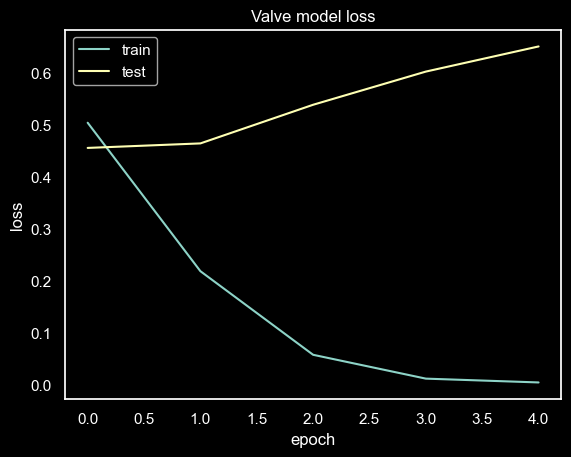

In [21]:

plt.style.use('dark_background')

plt.plot(history_valve.history['loss'])
plt.plot(history_valve.history['val_loss'])
plt.title('Valve model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
X, y = create_training_data(pump_df)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

# Define the input shape
input_shape = (160000,)
learning_rate = 0.001

# Build the model
model_pump = build_model_binary_classification(input_shape, learning_rate)
print(model_pump.summary())

Training data shape: (3364, 160000), Training labels shape: (3364,)
Testing data shape: (841, 160000), Testing labels shape: (841,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,120,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,120,577 (19.53 MB)

 Trainable params: 5,120,577 (19.53 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
# Example shapes (already defined):
# X_train.shape == (3275, 160000)
# y_train.shape == (3275,)
# X_test.shape == (819, 160000)
# y_test.shape == (819,)

# Train the model
history_pump = model_pump.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
evaluation_pump = model_pump.evaluate(X_test, y_test)
print(f"Test Accuracy: {evaluation_pump[1]}")
print(f"Test Precision: {evaluation_pump[2]}")
print(f"Test Recall: {evaluation_pump[3]}")


Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8612 - loss: 0.5988 - precision: 0.1354 - recall: 0.0646 - val_accuracy: 0.8728 - val_loss: 0.3895 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9019 - loss: 0.2157 - precision: 0.7477 - recall: 0.0302 - val_accuracy: 0.8787 - val_loss: 0.4279 - val_precision: 1.0000 - val_recall: 0.0467
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9601 - loss: 0.0723 - precision: 0.9813 - recall: 0.5989 - val_accuracy: 0.8811 - val_loss: 0.4929 - val_precision: 0.7333 - val_recall: 0.1028
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9964 - loss: 0.0200 - precision: 1.0000 - recall: 0.9644 - val_accuracy: 0.8811 - val_loss: 0.5539 - val_precision: 0.6842 - val_recall: 0.1215
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0067 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8811 - val_

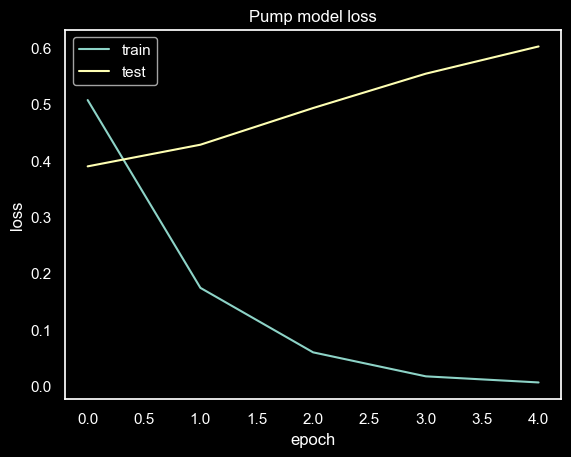

In [20]:

plt.style.use('dark_background')

plt.plot(history_pump.history['loss'])
plt.plot(history_pump.history['val_loss'])
plt.title('Pump model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()